# <center>Potatoes Disease Classification<center>

### Import Libraries

In [23]:
import warnings
warnings.filterwarnings('ignore')

In [62]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

import numpy as np
import os

In [56]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 12

In [26]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    '../data',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = 32
)

Found 2152 files belonging to 3 classes.


In [27]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [28]:
len(dataset)

68

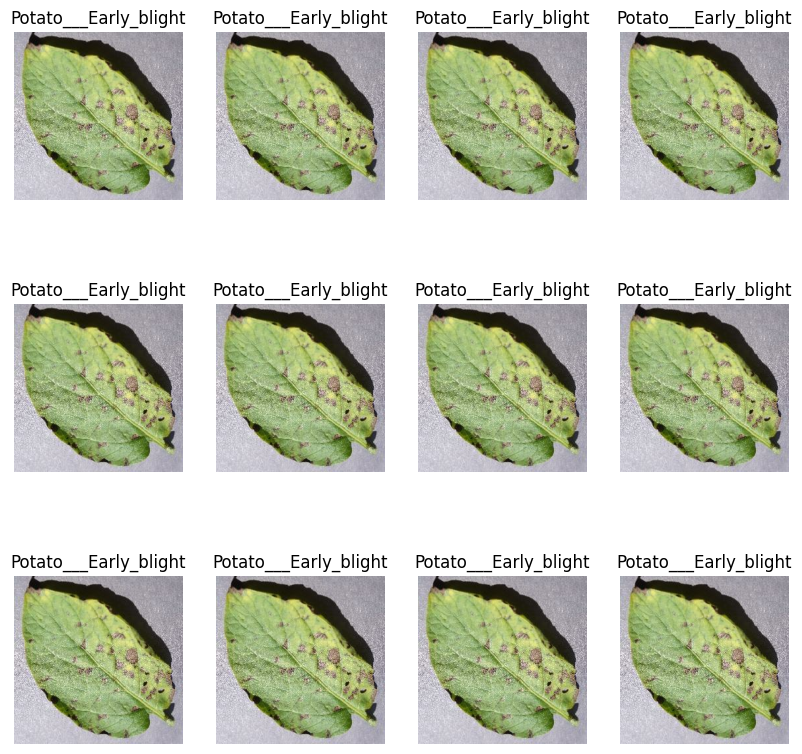

In [29]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype('uint8'))
        plt.title(class_names[label_batch[0]])
        plt.axis('off')

### Data splitting

In [30]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [31]:
train_ds = dataset.take(54)
len(train_ds)

54

In [32]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [33]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [34]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [35]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [36]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [37]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [38]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

In [39]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### Data Augmentation

In [40]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [41]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### Model Building

In [42]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [44]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [46]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=12,
)

Epoch 1/12
54/54 [==============================] - 35s 642ms/step - loss: 0.0930 - accuracy: 0.9618 - val_loss: 0.0870 - val_accuracy: 0.9740
Epoch 2/12
54/54 [==============================] - 34s 623ms/step - loss: 0.0627 - accuracy: 0.9786 - val_loss: 0.1598 - val_accuracy: 0.9427
Epoch 3/12
54/54 [==============================] - 34s 632ms/step - loss: 0.0828 - accuracy: 0.9647 - val_loss: 0.0777 - val_accuracy: 0.9740
Epoch 4/12
54/54 [==============================] - 33s 620ms/step - loss: 0.0481 - accuracy: 0.9850 - val_loss: 0.0623 - val_accuracy: 0.9740
Epoch 5/12
54/54 [==============================] - 34s 631ms/step - loss: 0.0689 - accuracy: 0.9757 - val_loss: 0.3006 - val_accuracy: 0.9323
Epoch 6/12
54/54 [==============================] - 36s 661ms/step - loss: 0.0739 - accuracy: 0.9740 - val_los

In [47]:
score = model.evaluate(test_ds)

2024-01-22 12:40:18.623627: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 32 of 10000
2024-01-22 12:40:25.973426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2024-01-22 12:40:25.973770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1 of 1000
2024-01-22 12:40:25.973875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


8/8 [==============================] - 19s 168ms/step - loss: 0.0796 - accuracy: 0.9766


In [48]:
score

[0.07962143421173096, 0.9765625]

### Plotting the Accuracy and Loss Curves

In [49]:
history.params

{'verbose': 1, 'epochs': 12, 'steps': 54}

In [50]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [51]:
type(history.history['loss'])

list

In [52]:
len(history.history['loss'])

12

In [53]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.0930284857749939,
 0.06267189234495163,
 0.08276620507240295,
 0.048069387674331665,
 0.06891714036464691]

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

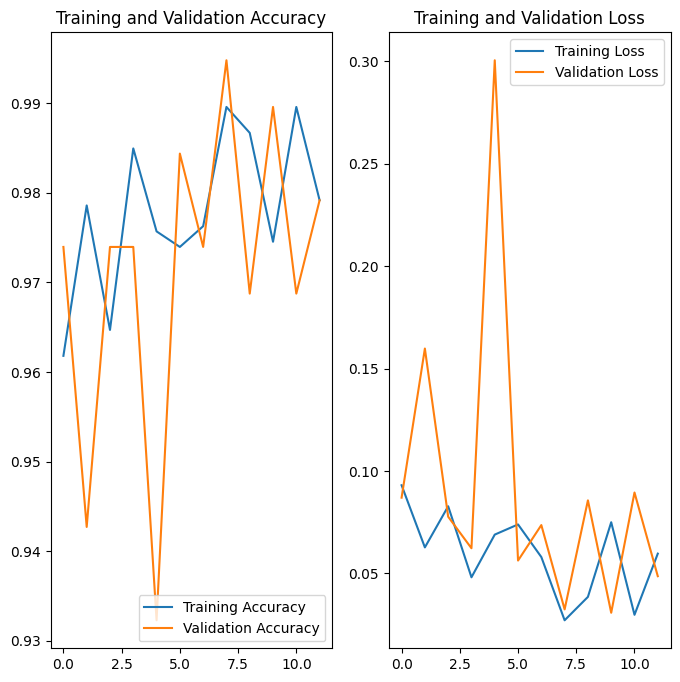

In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Running the Prediction

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 350ms/step
predicted label: Potato___Early_blight


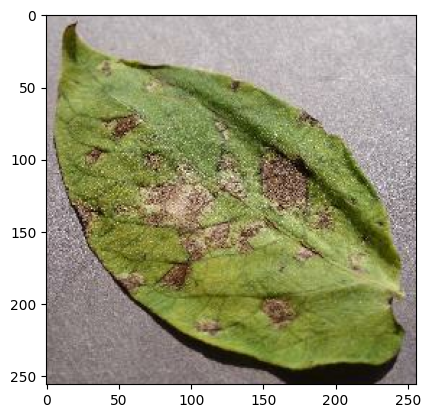

In [59]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


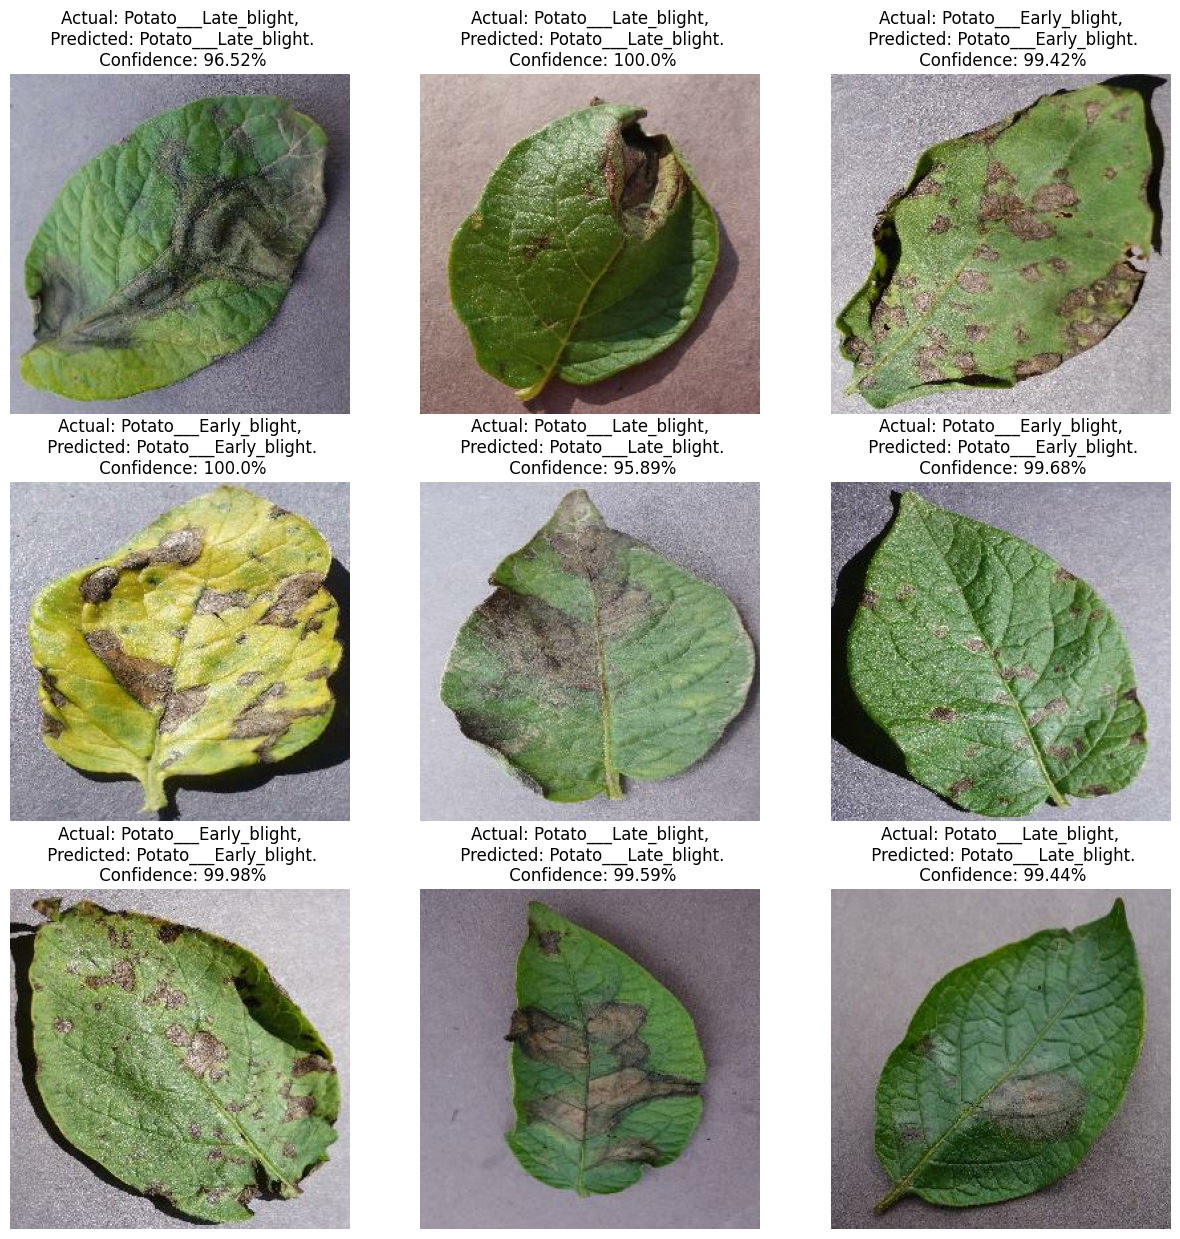

In [61]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model

In [65]:
model_version=max([int(i) for i in os.listdir("../model/") + [0]])+1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1/assets


INFO:tensorflow:Assets written to: ../model/1/assets


In [67]:
model.save("../model/potatoes.h5")